<a href="https://colab.research.google.com/github/mehrdadzaa/Mehrdadza/blob/main/Prkinson_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**`Preprocessing`**


In [ ]:
# import the necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate


# Load the dataset
df = pd.read_csv('/content/voice_features (3) - Combined.csv')

# Display the first few rows to understand its structure
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))

#check the data types and a summary to ensure everything is as expected
print(df.dtypes)
print(df.describe())

# apply the StandardScaler
# 'Subject', 'Status'and 'sex', we exclude them from scaling
features = df.select_dtypes(include=['float64', 'int64']).columns.drop(['Status'])
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to understand its structure
print(tabulate(df.head(), headers='keys', tablefmt='pretty'))


+---+-----------+-----------+-----------+-----------+-------------------+-------------+--------------+-------------+------------+-----------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------------------------+--------+
|   |  Mean F0  |  STD F0   |  Max F0   |  Min F0   | Spectral Centroid |   Jitter    |   Shimmer    |    LZ-2     |   MFCC0    |   MFCC1   |   MFCC2    |   MFCC3   |   MFCC4    |   MFCC5    |   MFCC6    |   MFCC7    |   MFCC8    |   MFCC9    |   MFCC10   |   MFCC11   |   MFCC12   |            Filename             | Status |
+---+-----------+-----------+-----------+-----------+-------------------+-------------+--------------+-------------+------------+-----------+------------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+---------------------------------+--------+
| 0 | 502.9454  | 3

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.model_selection import cross_val_score


# Prepare data for training
X = df.drop([ 'Status', 'Filename'], axis=1)  # Features
y = df['Status']  # Target variable

# Define K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=41)

# Function to perform grid search and return the best model
def perform_grid_search(clf, params, X, y, kf):
    scorer = make_scorer(roc_auc_score)
    grid_search = GridSearchCV(clf, params, scoring=scorer, cv=kf)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# XGBoost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 9]
}
xgb_best = perform_grid_search(xgb_clf, xgb_params, X, y, kf)
xgb_scores = cross_val_score(xgb_best, X, y, cv=kf, scoring='roc_auc')
print("XGBoost AUC (K-fold):", xgb_scores.mean())

# SVM
svm_clf = SVC(probability=True)
svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf']
}
svm_best = perform_grid_search(svm_clf, svm_params, X, y, kf)
svm_scores = cross_val_score(svm_best, X, y, cv=kf, scoring='roc_auc')
print("SVM AUC (K-fold):", svm_scores.mean())

# Logistic Regression
logreg_clf = LogisticRegression(max_iter=5000)
logreg_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']
}
logreg_best = perform_grid_search(logreg_clf, logreg_params, X, y, kf)
logreg_scores = cross_val_score(logreg_best, X, y, cv=kf, scoring='roc_auc')
print("Logistic Regression AUC (K-fold):", logreg_scores.mean())

# Perceptron model
perceptron_clf = Perceptron(max_iter=1000)
perceptron_params = {
    'alpha': [0.0001, 0.001, 0.1],
    'penalty': ['l1', 'l2', 'elasticnet']
}
perceptron_best = perform_grid_search(perceptron_clf, perceptron_params, X, y, kf)
perceptron_scores = cross_val_score(perceptron_best, X, y, cv=kf, scoring='roc_auc')
print("Perceptron AUC (K-fold):", perceptron_scores.mean())

XGBoost AUC (K-fold): 0.8413028375992772
SVM AUC (K-fold): 0.8843466241647355
Logistic Regression AUC (K-fold): 0.899736361706176
Perceptron AUC (K-fold): 0.9079108026476448


In [ ]:
xgb_feature_importances = xgb_best.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importances})
top_10_xgb_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)
print("Top 5 important features for XGBoost:")
print(top_10_xgb_features)

logreg_coefficients = logreg_best.coef_[0]
feature_coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg_coefficients})
top_10_logreg_features = feature_coef_df.reindex(feature_coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(5)
print("Top 5 important features for Logistic Regression:")
print(top_10_logreg_features)

Top 5 important features for XGBoost:
   Feature  Importance
0  Mean F0    0.128676
7     LZ-2    0.109119
6  Shimmer    0.092532
9    MFCC1    0.092270
3   Min F0    0.072888
Top 5 important features for Logistic Regression:
              Feature  Coefficient
9               MFCC1    -2.133743
8               MFCC0     1.212114
11              MFCC3     1.201720
6             Shimmer    -1.065013
4   Spectral Centroid    -0.708902


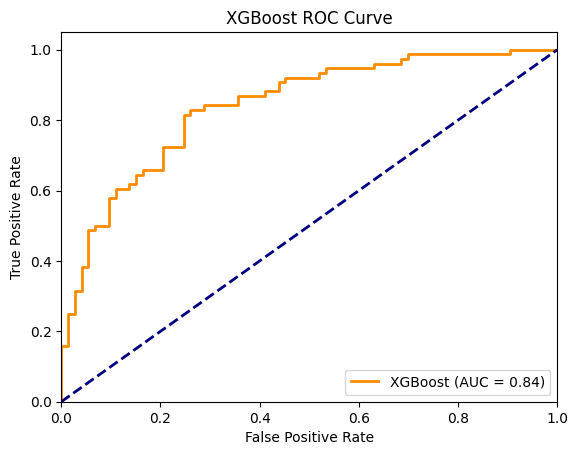

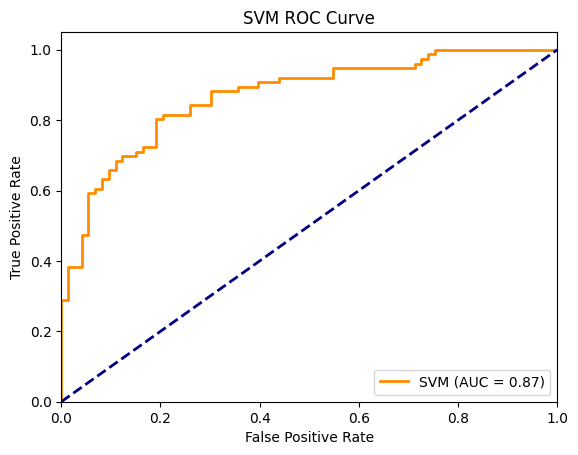

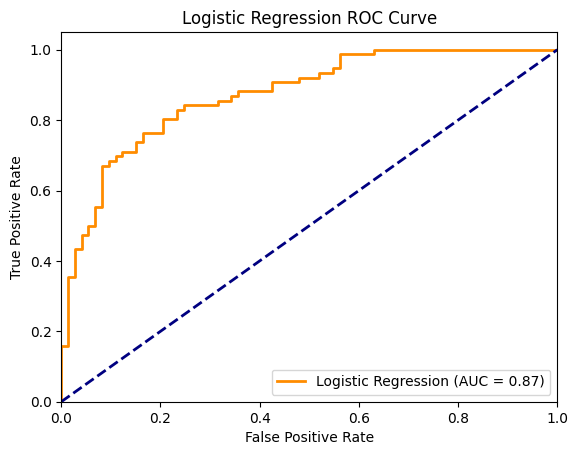

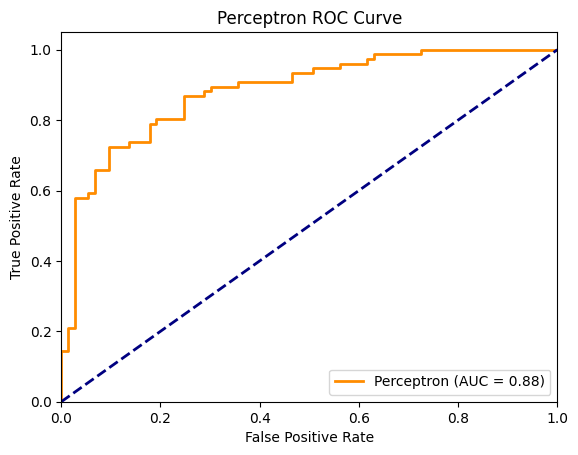

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

# Function to plot ROC curve
def plot_roc_curve(y_true, y_probas, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_probas)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=model_name + ' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# XGBoost
y_probas_xgb = cross_val_predict(xgb_best, X, y, cv=kf, method='predict_proba')
plot_roc_curve(y, y_probas_xgb[:, 1], 'XGBoost')

# SVM
y_scores_svm = cross_val_predict(svm_best, X, y, cv=kf, method='decision_function')
plot_roc_curve(y, y_scores_svm, 'SVM')

# Logistic Regression
y_probas_logreg = cross_val_predict(logreg_best, X, y, cv=kf, method='predict_proba')
plot_roc_curve(y, y_probas_logreg[:, 1], 'Logistic Regression')

# Perceptron
y_scores_perceptron = cross_val_predict(perceptron_best, X, y, cv=kf, method='decision_function')
plot_roc_curve(y, y_scores_perceptron, 'Perceptron')